In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!pip install pyLDAvis

     |████████████████████████████████| 1.6MB 2.8MB/s 
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis


In [0]:
!pip install textstat

     |████████████████████████████████| 3.0MB 4.2MB/s 


In [0]:
!pip install xlsxwriter

     |████████████████████████████████| 143kB 2.8MB/s 


In [0]:
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import tqdm as tqdm
import json
import string
import random
import operator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from statistics import *
from sklearn.feature_extraction.text import CountVectorizer
import concurrent.futures
import time
import pyLDAvis.sklearn
from pylab import bone, pcolor, colorbar, plot, show, rcParams, savefig
import textstat
import warnings
import nltk
import xlsxwriter
warnings.filterwarnings('ignore')

color = sns.color_palette()


pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

%matplotlib inline
import os

# spaCy based imports
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

import warnings
warnings.filterwarnings("ignore")

In [0]:
import xlsxwriter

In [0]:
# check current location
!pwd

/content


In [0]:
ls

drive/  sample_data/


In [0]:
# /content/drive/My Drive/Colab Notebooks/project_final/quora-insincere-questions-classification/

In [0]:
# load data
quora_train = pd.read_csv('... input/quora-insincere-questions-classification/train.csv')
quora_test = pd.read_csv('...input/quora-insincere-questions-classification/test.csv')

In [0]:
quora_train.shape

(1306122, 3)

In [0]:
quora_train.head(2)

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0


In [0]:
# spaCy parser for questions
# the special character
punctuations = string.punctuation
# the stopwords of english
stopwords = list(STOP_WORDS)

In [0]:
print(punctuations)
print(stopwords)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
['least', 'moreover', 'below', "'ll", 'am', 'done', 'own', 'thus', 'thereby', 'yourself', 'until', 'whoever', 'side', 'does', 'from', 'always', 'on', 'really', 'already', 'hereupon', '’ll', 'afterwards', 'eleven', 'four', 'mostly', 'up', 'front', 'serious', 'over', 'thru', 'what', 'put', 'name', 'say', 'everyone', 'hereby', 'is', 'whose', 'we', 'would', 'everything', 'the', 'there', 'throughout', 'which', 'therefore', 'every', 'himself', 'in', 'it', 'alone', 'may', 'however', 'namely', 'per', 're', 'thereupon', 'who', 'n’t', 'of', 'although', 'out', 'therein', 'go', 'again', 'nor', 'can', 'unless', 'whereas', 'that', 'others', 'anywhere', 'either', 'an', 'though', 'to', 'yourselves', 'since', 'anyway', 'noone', 'someone', 'through', 'none', 'and', 'perhaps', 'quite', 'regarding', 'give', 'together', 'ours', 'take', 'keep', 'as', 'just', 'various', 'former', 'toward', 'not', 'indeed', 'via', 'beforehand', 'ca', 'among', 'than', 'well', 'whatever', 'nowhe

In [0]:
parser = English()
print(parser)

1. preprocessing

In [0]:
def scapy_tokenizer(sentence):
  mytokens = parser(sentence)
  #print(mytokens)
  mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
  #print(mytokens)
  mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
  #print(mytokens)
  mytokens = " ".join([i for i in mytokens])
  return mytokens

In [0]:
scapy_tokenizer(quora_train.loc[0, 'question_text'])

'quebec nationalist province nation 1960s'

In [0]:
print(quora_train.loc[0, 'question_text'])

How did Quebec nationalists see their province as a nation in the 1960s?


In [0]:
# way 1
# for i in range(quora_train.shape[0]):
#   print(i)
#   quora_train.loc[i, 'question_text'] = scapy_tokenizer(quora_train.loc[i, 'question_text'])

# way 2
quora_train['question_norm'] = quora_train['question_text'].apply(scapy_tokenizer)
quora_test['question_norm'] = quora_test['question_text'].apply(scapy_tokenizer)

In [0]:

def remove_s(setences):
  return setences.replace('  ', '').strip().

In [0]:
a = 'quebec nationalist   province     nation 1960s     '
d = pd.DataFrame()
d['a'] = [a]
d['a'] = d['a'].apply(remove_s)
d

,a
0,quebec nationalist province nation 1960s


In [0]:
quora_train['question_text'] = quora_train['question_text'].apply(remove_s)
quora_train['question_norm'] = quora_train['question_norm'].apply(remove_s)

In [0]:
quora_test['question_text'] = quora_test['question_text'].apply(remove_s)
quora_test['question_norm'] = quora_test['question_norm'].apply(remove_s)

In [0]:
quora_train.shape

(1306122, 4)

In [0]:
# save file xlsx
writer = pd.ExcelWriter('...input/quora-insincere-questions-classification/quora_train.xlsx', engine= 'xlsxwriter')
quora_train.to_excel(writer, 'Sheet1')
writer.save()

writer1 = pd.ExcelWriter('...input/quora-insincere-questions-classification/quora_test.xlsx', engine= 'xlsxwriter')
quora_test.to_excel(writer1, 'Sheet1')
writer.save()

In [0]:
quora_train.head(2)

,qid,question_text,target,question_norm
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,quebec nationalist province nation 1960s
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,adopt dog encourage people adopt shop


In [0]:
# sincere_questions = quora_train["question_text"][quora_train["target"] == 0].apply(scapy_tokenizer)
# insincere_questions = quora_train["question_text"][quora_train["target"] == 1].apply(scapy_tokenizer)

In [0]:
# sincere_df = sincere_questions.to_frame()
# insincere_df = insincere_questions.to_frame()
# sincere_questions.to_frame().head(2)

In [0]:
# ls_sincere = list(sincere_df.question_text.values)
# ls_insincere = list(insincere_df.question_text.values)
# ls_w = ls_insincere + ls_sincere

2. data analysis

2.1 distribution of the word number in the sentence

In [0]:
def count_words(sentence):
  return len(sentence.split())

In [0]:
count_words(quora_train.loc[0, 'question_text'])

13

In [0]:
quora_train['count_word'] = quora_train['question_text'].apply(count_words)
quora_test['count_word'] = quora_test['question_text'].apply(count_words)

In [0]:
quora_train['count_word'].describe().astype('int')

count    1306122
mean          12
std            7
min            1
25%            8
50%           11
75%           15
max          134
Name: count_word, dtype: int64

In [0]:
ls_sequence = list(quora_train.question_norm)

In [0]:
# count the word number in the train set
str_senquence = " ".join(ls_sequence)
ls_word = list(set(str_senquence.split()))
len(ls_word)

204008

2.2 target distribution

In [0]:
df_count_target = quora_train.target.value_counts()
df_count_target

0    1225312
1      80810
Name: target, dtype: int64

In [0]:
sns.set(style = "whitegrid")

Text(0.5, 1.0, 'Target Count')

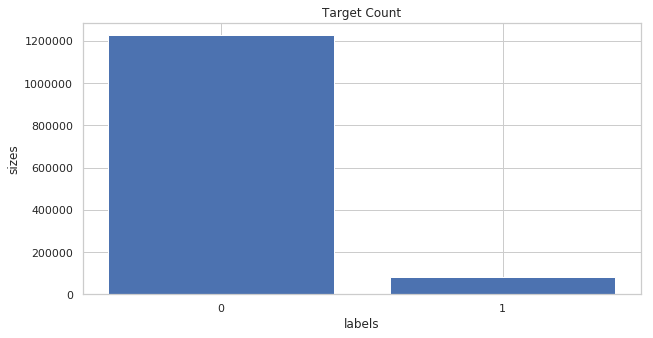

In [0]:
# target count
plt.figure(figsize= (10, 5))
plt.bar(df_count_target.index, df_count_target.values, label = df_count_target.index)
plt.xticks( df_count_target.index)
plt.xlabel('labels')
plt.ylabel('sizes')
plt.title('Target Count')

[0 1]
[93.81298225  6.18701775]


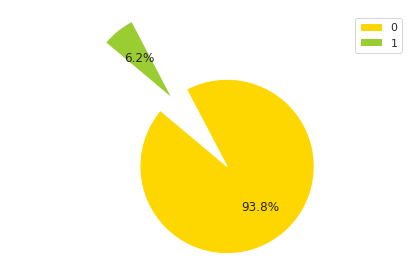

In [0]:
# target distribution
labels = np.array(df_count_target.index)
sizes = np.array((df_count_target/df_count_target.sum())*100)
colors = ['gold', 'yellowgreen']
print(labels)
print(sizes)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels, colors= colors, autopct = '%1.1f%%', startangle= 140)
plt.legend(labels, loc= "best")
plt.axis('equal')
plt.tight_layout()
plt.show()

2.3 word, bigram, trigram frequency plot of sincere & insincere question use n-gram

In [0]:
quora_train.columns

Index(['qid', 'question_text', 'target', 'question_norm', 'count_word'], dtype='object')

In [0]:
quora_train = quora_train[['target', 'question_text']]

In [0]:
from collections import defaultdict
# create a dataframe, train1_df, contain the insincere data
train1_df = quora_train[quora_train["target"] == 1]
# create a dataframe, train0_df, contain the sincere data
train0_df = quora_train[quora_train["target"] == 0]

In [0]:
# custom function for ngram generator
def generate_ngrams(text, n_gram= 3):
  token = [token for token in text.lower().split(" ") if token != "" if token not in STOP_WORDS]
  #print(token)
  ngrams = zip(*[token[i:] for i in range(n_gram)])
  #print(ngrams)
  return "|".join([" ".join(ngram) for ngram in ngrams])

In [0]:
print(quora_train.loc[0, 'question_text'])
print(generate_ngrams(quora_train.loc[0, 'question_text'], 2))
print(generate_ngrams(quora_train.loc[0, 'question_text'], 1))

How did Quebec nationalists see their province as a nation in the 1960s?
quebec nationalists|nationalists province|province nation|nation 1960s?
quebec|nationalists|province|nation|1960s?


In [0]:
train0_df= train0_df.reset_index()
train0_df = train0_df.drop('index', axis= 1)
train1_df= train1_df.reset_index()
train1_df = train1_df.drop('index', axis= 1)

In [0]:
train0_df.head(2)

,target,question_text
0,0,How did Quebec nationalists see their province...
1,0,"Do you have an adopted dog, how would you enco..."


In [0]:
train0_df['word_frequency'] = train0_df['question_text'].apply(generate_ngrams)
train1_df['word_frequency'] = train1_df['question_text'].apply(generate_ngrams)

In [0]:
train0_df['biggram_frequency'] = train0_df['question_text'].apply(generate_ngrams)
train1_df['biggram_frequency'] = train1_df['question_text'].apply(generate_ngrams)

In [0]:
train0_df['trigram_frequency'] = train0_df['question_text'].apply(generate_ngrams)
train1_df['trigram_frequency'] = train1_df['question_text'].apply(generate_ngrams)

In [0]:
train0_df.head(2)

,target,question_text,word_frequency,biggram_frequency,trigram_frequency
0,0,How did Quebec nationalists see their province...,quebec|nationalists|province|nation|1960s?,quebec nationalists|nationalists province|prov...,quebec nationalists province|nationalists prov...
1,0,"Do you have an adopted dog, how would you enco...","adopted|dog,|encourage|people|adopt|shop?","adopted dog,|dog, encourage|encourage people|p...","adopted dog, encourage|dog, encourage people|e..."


In [0]:
# save file xlsx
# writer = pd.ExcelWriter('/content/drive/My Drive/Colab Notebooks/project_final/quora-insincere-questions-classification/sincere.xlsx', engine= 'xlsxwriter')
# train0_df.to_excel(writer, 'Sheet1')
# writer.save()

# writer1 = pd.ExcelWriter('/content/drive/My Drive/Colab Notebooks/project_final/quora-insincere-questions-classification/insincere.xlsx', engine= 'xlsxwriter')
# train1_df.to_excel(writer1, 'Sheet1')
# writer.save()

In [0]:
# words
ls_word_sincere = "|".join(list(train0_df.word_frequency.values))
ls_word_sincere = ls_word_sincere.split('|')
print(ls_word_sincere[:3])
ls_word_insincere = "|".join(list(train1_df.word_frequency.values))
ls_word_insincere = ls_word_insincere.split('|')
print(ls_word_insincere[:3])

['quebec', 'nationalists', 'province']
['united', 'states', 'largest']


In [0]:
# create a new dataframe, df_word_sincere, contain the list of the words in all sincere sentences
df_word_sincere = pd.DataFrame()
df_word_sincere['word'] = ls_word_sincere
df_word_sincere = df_word_sincere['word'].value_counts().to_frame()
df_word_sincere = df_word_sincere.reset_index()
df_word_sincere.columns = ["word", "wordcount"]
# create a new dataframe, df_word_insincere, contain the list of the words in all sincere sentences
df_word_insincere = pd.DataFrame()
df_word_insincere['word'] = ls_word_insincere
df_word_insincere = df_word_insincere['word'].value_counts().to_frame()
df_word_insincere = df_word_insincere.reset_index()
df_word_insincere.columns = ["word", "wordcount"]

In [0]:
df_word_insincere.head(2)

,word,wordcount
0,people,11036
1,like,5708


In [0]:
df_word_sincere.head(2)

,word,wordcount
0,best,60816
1,people,37960


In [0]:
ls_insincere_ex = list(df_word_insincere[df_word_insincere.wordcount <=10].word.values)
ls_sincere_ex = list(df_word_sincere[df_word_sincere.wordcount <=10].word.values)
print(ls_insincere_ex[:3])

['slightest', 'soil?', 'power.']


In [0]:
ls_excess_word = ls_insincere_ex + ls_sincere_ex
len(ls_excess_word)

453013

In [0]:
ex_w = "\n".join(ls_excess_word)
# Append-adds at last 
file1 = open("/content/drive/My Drive/Colab Notebooks/project_final/quora-insincere-questions-classification/excess_word.txt","w")#append mode 
file1.write(ex_w) 
file1.close()

453013

In [0]:
df_word_insincere.head(3).iloc[::-1, :]

,word,wordcount
2,trump,4893
1,like,5708
0,people,11036


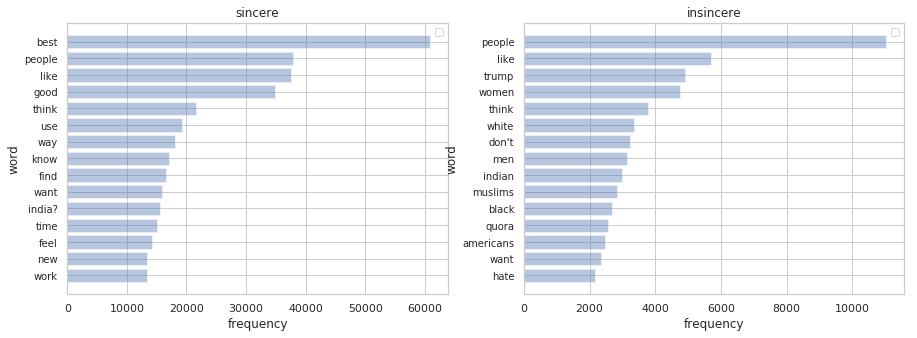

In [0]:
# top 15 most popular words of sincere and insincere question
df0 = df_word_sincere.head(15).iloc[::-1, :]
df0 = df0.reset_index()
df0 = df0.drop(columns= ['index'], axis= 1)
df1 = df_word_insincere.head(15).iloc[::-1, :]
df1 = df1.reset_index()
df1 = df1.drop(columns= ["index"], axis = 1)

plt.figure(figsize= (15,5))
plt.subplot(1, 2, 1)
plt.barh(np.array(df0.index), np.array(df0.wordcount), align= "center", alpha= 0.4)
plt.title('sincere')
plt.yticks(df0.index, df0.word, fontsize= 10)
plt.legend(df0.index, df0.word, loc= "best", prop= {'size': 10})
plt.xlabel('frequency')
plt.ylabel('word')

plt.subplot(1, 2, 2)
plt.barh(df1.index, df1.wordcount, align= "center", alpha = 0.4)
plt.legend(df1.index, df1.word, loc= "best", prop= {'size': 10})
plt.title('insincere')
plt.yticks(df1.index, df1.word, fontsize= 10)
plt.xlabel('frequency')
plt.ylabel('word')

plt.show()

In [0]:
# bigram
ls_bigram_sincere = "|".join(list(train0_df.biggram_frequency.values))
ls_bigram_sincere = ls_bigram_sincere.split('|')
print(ls_bigram_sincere[:3])
ls_bigram_insincere = "|".join(list(train1_df.biggram_frequency.values))
ls_bigram_insincere = ls_bigram_insincere.split('|')
print(ls_bigram_insincere[:3])

['quebec nationalists', 'nationalists province', 'province nation']
['united states', 'states largest', 'largest dictatorship']


In [0]:
# create a new dataframe, df_bigram_sincere, contain the list of the bigrams in all sincere sentences
df_bigram_sincere = pd.DataFrame()
df_bigram_sincere['word'] = ls_bigram_sincere
df_bigram_sincere = df_bigram_sincere['word'].value_counts().to_frame()
df_bigram_sincere = df_bigram_sincere.reset_index()
df_bigram_sincere.columns = ["bigram", "bigramcount"]
# create a new dataframe, df_bigram_insincere, contain the list of the bigram in all sincere sentences
df_bigram_insincere = pd.DataFrame()
df_bigram_insincere['word'] = ls_bigram_insincere
df_bigram_insincere = df_bigram_insincere['word'].value_counts().to_frame()
df_bigram_insincere = df_bigram_insincere.reset_index()
df_bigram_insincere.columns = ["bigram", "bigramcount"]

In [0]:
df_bigram_sincere.head(2)

,bigram,bigramcount
0,,8654
1,best way,6974


In [0]:
df_bigram_sincere = df_bigram_sincere.drop([0], axis= 0)

In [0]:
df_bigram_sincere = df_bigram_sincere.reset_index()
df_bigram_sincere = df_bigram_sincere.drop('index', axis= 1)

In [0]:
df_bigram_sincere.head(2)

,bigram,bigramcount
0,best way,6974
1,year old,2972


In [0]:
df_bigram_insincere[df_bigram_insincere.bigramcount >200].shape

(15, 2)

In [0]:
df_bigram_sincere[df_bigram_sincere.bigramcount >500].shape

(77, 2)

In [0]:
ls_big_sin = list(df_bigram_sincere[df_bigram_sincere.bigramcount >500].bigram.values)
ls_big_insin = list(df_bigram_insincere[df_bigram_insincere.bigramcount >200].bigram.values)
ls_important_bigram = ls_big_sin + ls_big_insin
len(ls_important_bigram)

92

In [ ]:
ls_important_bigram2 = []
for i in range(len(ls_important_bigram)):
    ls_important_bigram2.append(ls_important_bigram[i].strip().replace(' ', '_'))

In [ ]:
big_w1 = "\n".join(ls_important_bigram)
# Append-adds at last 
file1 = open("/content/drive/My Drive/Colab Notebooks/project_final/quora-insincere-questions-classification/bigram_word1.txt","w")#append mode 
file1.write(big_w1) 
file1.close()
big_w2 = "\n".join(ls_important_bigram2)
# Append-adds at last 
file2 = open("/content/drive/My Drive/Colab Notebooks/project_final/quora-insincere-questions-classification/bigram_word2.txt","w")#append mode 
file2.write(big_w2) 
file2.close()

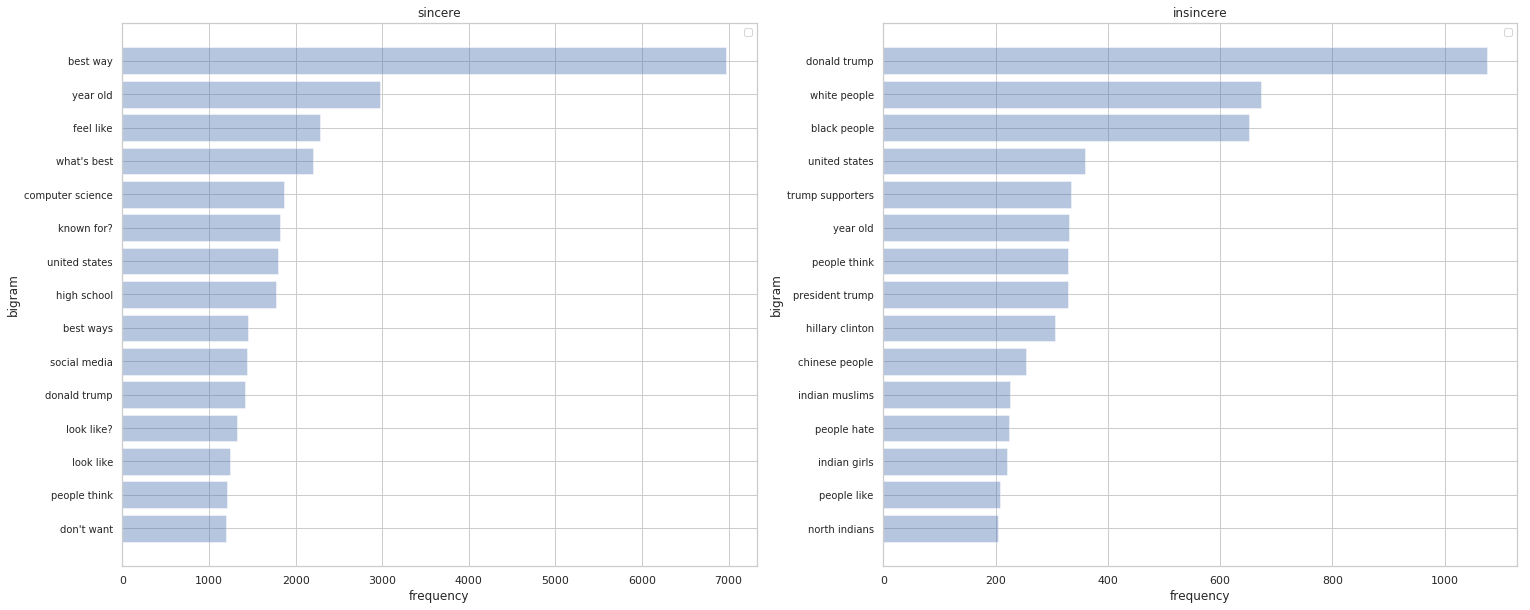

In [0]:
# top 15 most popular bigram of sincere and insincere question
df0 = df_bigram_sincere.head(15).iloc[::-1, :]
df0 = df0.reset_index()
df0 = df0.drop(columns= ['index'], axis= 1)
df1 = df_bigram_insincere.head(15).iloc[::-1, :]
df1 = df1.reset_index()
df1 = df1.drop(columns= ["index"], axis = 1)

plt.figure(figsize= (25,10))
plt.subplot(1, 2, 1)
plt.barh(np.array(df0.index), np.array(df0.bigramcount), align= "center", alpha= 0.4)
plt.title('sincere')
plt.yticks(df0.index, df0.bigram, fontsize= 10)
plt.legend(df0.index, df0.bigram, loc= "best", prop= {'size': 10})
plt.xlabel('frequency')
plt.ylabel('bigram')

plt.subplot(1, 2, 2)
plt.barh(df1.index, df1.bigramcount, align= "center", alpha = 0.4)
plt.legend(df1.index, df1.bigram, loc= "best", prop= {'size': 10})
plt.title('insincere')
plt.yticks(df1.index, df1.bigram, fontsize= 10)
plt.xlabel('frequency')
plt.ylabel('bigram')

plt.show()

In [0]:
# bigram
ls_trigram_sincere = "|".join(list(train0_df.trigram_frequency.values))
ls_trigram_sincere = ls_trigram_sincere.split('|')
print(ls_trigram_sincere[:3])
ls_trigram_insincere = "|".join(list(train1_df.trigram_frequency.values))
ls_trigram_insincere = ls_trigram_insincere.split('|')
print(ls_trigram_insincere[:3])

['quebec nationalists province', 'nationalists province nation', 'province nation 1960s?']
['united states largest', 'states largest dictatorship', 'largest dictatorship world?']


In [0]:
# create a new dataframe, df_bigram_sincere, contain the list of the bigrams in all sincere sentences
df_trigram_sincere = pd.DataFrame()
df_trigram_sincere['word'] = ls_trigram_sincere
df_trigram_sincere = df_trigram_sincere['word'].value_counts().to_frame()
df_trigram_sincere = df_trigram_sincere.reset_index()
df_trigram_sincere.columns = ["bigram", "bigramcount"]
# create a new dataframe, df_bigram_insincere, contain the list of the bigram in all sincere sentences
df_trigram_insincere = pd.DataFrame()
df_trigram_insincere['word'] = ls_trigram_insincere
df_trigram_insincere = df_trigram_insincere['word'].value_counts().to_frame()
df_trigram_insincere = df_trigram_insincere.reset_index()
df_trigram_insincere.columns = ["bigram", "bigramcount"]

In [0]:
df_trigram_sincere.head(2)

,bigram,bigramcount
0,,78525
1,what's best way,832


In [0]:
df_trigram_sincere = df_trigram_sincere.drop([0], axis= 0)
df_trigram_sincere = df_trigram_sincere.reset_index()
df_trigram_sincere = df_trigram_sincere.drop('index', axis= 1)

In [0]:
df_trigram_sincere.head(2)

,bigram,bigramcount
0,what's best way,832
1,useful tips starting,714


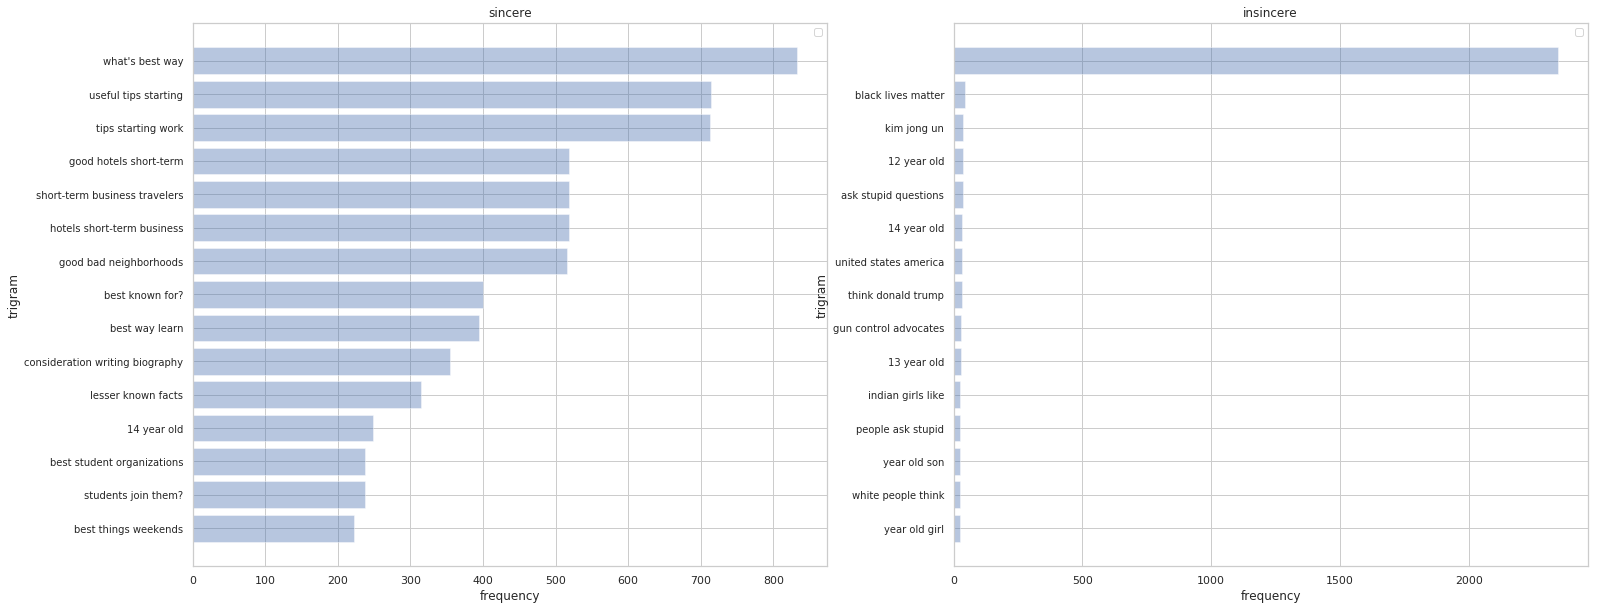

In [0]:
# top 15 most popular trigram of sincere and insincere question
df0 = df_trigram_sincere.head(15).iloc[::-1, :]
df0 = df0.reset_index()
df0 = df0.drop(columns= ['index'], axis= 1)
df1 = df_trigram_insincere.head(15).iloc[::-1, :]
df1 = df1.reset_index()
df1 = df1.drop(columns= ["index"], axis = 1)

plt.figure(figsize= (25,10))
plt.subplot(1, 2, 1)
plt.barh(np.array(df0.index), np.array(df0.bigramcount), align= "center", alpha= 0.4)
plt.title('sincere')
plt.yticks(df0.index, df0.bigram, fontsize= 10)
plt.legend(df0.index, df0.bigram, loc= "best", prop= {'size': 10})
plt.xlabel('frequency')
plt.ylabel('trigram')

plt.subplot(1, 2, 2)
plt.barh(df1.index, df1.bigramcount, align= "center", alpha = 0.4)
plt.legend(df1.index, df1.bigram, loc= "best", prop= {'size': 10})
plt.title('insincere')
plt.yticks(df1.index, df1.bigram, fontsize= 10)
plt.xlabel('frequency')
plt.ylabel('trigram')

plt.show()

In [0]:
# del df_word_insincere
# del df_word_sincere
# del df_bigram_insincere
# del df_bigram_sincere
# del df_trigram_insincere
# del df_trigram_sincere

In [0]:
x_train = pd.ExcelFile('/content/drive/My Drive/Colab Notebooks/project_final/quora-insincere-questions-classification/quora_train.xlsx')
quora_train = x_train.parse('Sheet1')
x_test = pd.ExcelFile('/content/drive/My Drive/Colab Notebooks/project_final/quora-insincere-questions-classification/quora_test.xlsx')
quora_test = x_test.parse('Sheet1')

In [0]:
quora_train.head(2)

,Unnamed: 0,qid,question_text,target,question_norm
0,0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,quebec nationalist province nation 1960s
1,1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,adopt dog encourage people adopt shop


In [0]:
quora_test.head(2)

,Unnamed: 0,qid,question_text,question_norm
0,0,0000163e3ea7c7a74cd7,Why do so many women become so rude and arroga...,woman rude arrogant little bite wealth power
1,1,00002bd4fb5d505b9161,When should I apply for RV college of engineer...,apply rv college engineer bms college engineer...


In [0]:
## Number of words in the text ##
quora_train["num_words"] = quora_train["question_text"].apply(lambda x: len(str(x).split()))
quora_test["num_words"] = quora_test["question_text"].apply(lambda x: len(str(x).split()))

## Number of unique words in the text ##
quora_train["num_unique_words"] = quora_train["question_text"].apply(lambda x: len(set(str(x).split())))
quora_test["num_unique_words"] = quora_test["question_text"].apply(lambda x: len(set(str(x).split())))

## Number of characters in the text ##
quora_train["num_chars"] = quora_train["question_text"].apply(lambda x: len(str(x)))
quora_test["num_chars"] = quora_test["question_text"].apply(lambda x: len(str(x)))

## Number of stopwords in the text ##
quora_train["num_stopwords"] = quora_train["question_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in stopwords]))
quora_test["num_stopwords"] = quora_test["question_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in stopwords]))

## Number of punctuations in the text ##
quora_train["num_punctuations"] = quora_train['question_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
quora_test["num_punctuations"] = quora_test['question_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

## Number of title case words in the text ##
quora_train["num_words_upper"] = quora_train["question_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
quora_test["num_words_upper"] = quora_test["question_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## Number of title case words in the text ##
quora_train["num_words_title"] = quora_train["question_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
quora_test["num_words_title"] = quora_test["question_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

## Average length of the words in the text ##
quora_train["mean_word_len"] = quora_train["question_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
quora_test["mean_word_len"] = quora_test["question_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [0]:
quora_train.head(2)

,Unnamed: 0,qid,question_text,target,question_norm,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,num_words_title,mean_word_len
0,0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,quebec nationalist province nation 1960s,13,13,72,8,1,0,2,4.615385
1,1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,adopt dog encourage people adopt shop,16,15,81,10,2,0,1,4.125000


In [0]:
quora_train.columns

Index(['Unnamed: 0', 'qid', 'question_text', 'target', 'question_norm',
       'num_words', 'num_unique_words', 'num_chars', 'num_stopwords',
       'num_punctuations', 'num_words_upper', 'num_words_title',
       'mean_word_len'],
      dtype='object')

In [0]:
quora_train[['num_words', 'num_unique_words', 'num_chars', 'num_stopwords', 'num_punctuations', 'num_words_upper', 'num_words_title', 'mean_word_len']].describe()

,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,num_words_title,mean_word_len
count,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06
mean,1.280214e+01,1.213435e+01,7.067135e+01,6.663821e+00,1.746231e+00,4.503693e-01,2.120054e+00,4.671121e+00
std,7.048434e+00,6.036137e+00,3.876389e+01,4.111713e+00,1.694237e+00,8.494591e-01,1.493017e+00,8.190567e-01
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
25%,8.000000e+00,8.000000e+00,4.500000e+01,4.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,4.111111e+00
50%,1.100000e+01,1.100000e+01,6.000000e+01,6.000000e+00,1.000000e+00,0.000000e+00,2.000000e+00,4.600000e+00
75%,1.500000e+01,1.500000e+01,8.500000e+01,8.000000e+00,2.000000e+00,1.000000e+00,3.000000e+00,5.142857e+00
max,1.340000e+02,9.600000e+01,1.017000e+03,6.000000e+01,4.110000e+02,3.700000e+01,3.000000e+01,5.766667e+01


In [0]:
quora_train[['num_words', 'num_unique_words', 'num_chars', 'num_stopwords', 'num_punctuations', 'num_words_upper', 'num_words_title', 'mean_word_len']].describe().style.format("{:.2f}")

,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,num_words_title,mean_word_len
count,1048575.00,1048575.00,1048575.00,1048575.00,1048575.00,1048575.00,1048575.00,1048575.00
mean,12.80,12.13,70.67,6.66,1.75,0.45,2.12,4.67
std,7.05,6.04,38.76,4.11,1.69,0.85,1.49,0.82
min,1.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00
25%,8.00,8.00,45.00,4.00,1.00,0.00,1.00,4.11
50%,11.00,11.00,60.00,6.00,1.00,0.00,2.00,4.60
75%,15.00,15.00,85.00,8.00,2.00,1.00,3.00,5.14
max,134.00,96.00,1017.00,60.00,411.00,37.00,30.00,57.67


In [0]:
# save file xlsx
# writer = pd.ExcelWriter('/content/drive/My Drive/Colab Notebooks/project_final/quora-insincere-questions-classification/quora_train.xlsx', engine= 'xlsxwriter')
# quora_train.to_excel(writer, 'Sheet1')
# writer.save()

# writer1 = pd.ExcelWriter('/content/drive/My Drive/Colab Notebooks/project_final/quora-insincere-questions-classification/quora_test.xlsx', engine= 'xlsxwriter')
# quora_test.to_excel(writer1, 'Sheet1')
# writer.save()

# prepare training, validation, and test set

In [ ]:
quora_test = quora_test.replace(np.nan, '')
quora_train = quora_train.replace(np.nan, '')

In [0]:
# # save file xlsx
# writer = pd.ExcelWriter('/content/drive/My Drive/Colab Notebooks/project_final/quora-insincere-questions-classification/quora_train.xlsx', engine= 'xlsxwriter')
# quora_train.to_excel(writer, 'Sheet1')
# writer.save()

writer1 = pd.ExcelWriter('/content/drive/My Drive/Colab Notebooks/project_final/quora-insincere-questions-classification/quora_test.xlsx', engine= 'xlsxwriter')
quora_test.to_excel(writer1, 'Sheet1')
writer.save()

In [0]:
# x_train = pd.ExcelFile('/content/drive/My Drive/Colab Notebooks/project_final/quora-insincere-questions-classification/quora_train.xlsx')
# quora_train = x_train.parse('Sheet1')
# x_test = pd.ExcelFile('/content/drive/My Drive/Colab Notebooks/project_final/quora-insincere-questions-classification/quora_test.xlsx')
# quora_test = x_test.parse('Sheet1')

In [0]:
quora_train = quora_train.reset_index()
quora_train = quora_train.drop('index', axis= 1)
quora_train.shape

(1048575, 5)

In [0]:
def clean_text(x):

    x = str(x)
    for punct in "/-'":
        x = x.replace(punct, ' ')
    for punct in '&':
        x = x.replace(punct, f' {punct} ')
    for punct in '?!.,"#$%\'()*+-/:;<=>@[\\]^`{|}~' + '“”’':
        x = x.replace(punct, '')
    return x

In [0]:
quora_train['text_norm'] = quora_train.question_norm.apply(clean_text)

In [0]:
quora_test['text_norm'] = quora_test.question_norm.apply(clean_text)

In [0]:
# the_list = [2, 3, 1,9, 5, 6, 7, 10, 12, 34, 55, 66, 77,22, 21]
# import random
# a = random.sample(the_list, 5)
# print(a)
# print(set(the_list) - set(a))

[1, 9, 77, 34, 22]
{2, 3, 66, 5, 6, 7, 10, 12, 21, 55}


In [0]:
def common_member(a, b): 
    a_set = set(a) 
    b_set = set(b) 
    if len(a_set.intersection(b_set)) > 0: 
        return(True)  
    return(False) 
#print(common_member(a, list(set(the_list) - set(a))))

In [0]:
# take id of sincere and insincere question
id_sincere = list(quora_train[quora_train.target == 0].index)
id_insincere = list(quora_train[quora_train.target == 1].index)
print(len(id_sincere))
print(len(id_insincere))

983801
64774


In [0]:
# take random 20% id in the train set make validation set
id_sincere_val = random.sample(id_sincere, 230000)
id_insincere_val = random.sample(id_insincere, 11000)
id_val = id_sincere_val + id_insincere_val
print(len(id_sincere_val))
print(len(id_insincere_val))
print(len(id_val))

230000
11000
241000


In [0]:
# id_sincere_train = list(set(id_sincere) - set(id_sincere_val))
# id_insincere_train = list(set(id_insincere) - set(id_insincere_val))
# print(len(id_sincere_train))
# print(len(id_insincere_train))

In [0]:
df_quora_val = quora_train[quora_train.index.isin(id_val)]
df_quora_val.shape

(241000, 5)

In [0]:
df_quora_train = quora_train[~quora_train.index.isin(id_val)]
df_quora_train.shape

(807575, 5)

In [0]:
df_quora_val.shape[0]/quora_train.shape[0]

0.2298357294423384

In [0]:
print(common_member(list(df_quora_val.index), list(df_quora_train.index)))

False


In [0]:
df_quora_val = df_quora_val.reset_index()
df_quora_val = df_quora_val.drop('index', axis= 1)
df_quora_train = df_quora_train.reset_index()
df_quora_train = df_quora_train.drop('index', axis= 1)

In [0]:
df_quora_train.head(2)

,Unnamed: 0,qid,question_text,target,question_norm
0,0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,quebec nationalist province nation 1960s
1,1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,adopt dog encourage people adopt shop


In [0]:
df_quora_val['text_norm1'] = df_quora_val['question_norm'].apply(clean_text)

In [0]:
quora_test['text_norm1'] = quora_test['question_norm'].apply(clean_text)

In [0]:
df_quora_train['text_norm1'] = df_quora_train['question_norm'].apply(clean_text)

In [0]:
df_quora_train = df_quora_train.drop('question_norm', axis= 1)
df_quora_val = df_quora_val.drop('question_norm', axis=1)
quora_test= quora_test.drop('question_norm', axis= 1)

In [0]:
file1 = open("excess_word.txt","r+")  
key_ex = file1.read()
def remove_excess_word(text):
    str_text = text
    key_ex = key_ex.split('\n')
    key_ex = [clean_text(w) for w in key_ex]
    for word in text.split():
        if word in key_ex:
            str_text = str_text.replace(word, '')


    return str_text

KeyboardInterrupt: ignored

In [ ]:
file1 = open("bigram_word1.txt","r+")  
  
bigram1 = file1.read()
file2 = open("bigram_word2.txt","r+")  
  
bigram2 = file2.read()
print(bigram1.split('\n')[:2])
print(bigram2.split('\n')[:2])
ls_important_bigram = bigram1.split('\n')
ls_important_bigram2 = bigram2.split('\n')
def bigram_phrase(text):
    for i in range(len(ls_important_bigram)):
    
    if clean_text(ls_important_bigram[i].strip()) in text:
        #print(ls_important_bigram[i].strip())
        text = text.replace(ls_important_bigram[i].strip(), ls_important_bigram2[i].strip())

In [ ]:
df_quora_val['question_norm'] = df_quora_val['text_norm1'].apply(remove_excess_word)
df_quora_val['question_norm'] = df_quora_val['text_norm1'].apply(bigram_phrase)
df_quora_train['question_norm'] = quora_train['question_norm'].apply(remove_excess_word)
df_quora_train['question_norm'] = quora_train['question_norm'].apply(bigram_phrase)
df_quora_test['question_norm'] = quora_test['question_norm'].apply(remove_excess_word)
df_quora_test['question_norm'] = quora_test['question_norm'].apply(bigram_phrase)

In [0]:
df_quora_train.shape

(807575, 5)

In [0]:
int(807575/4)*2 + 200000

603786

In [0]:
df_quora_train = df_quora_train.drop('Unnamed: 0', axis= 1)

In [0]:
df_quora_train.head(2)

,qid,question_text,target,text_norm1
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,quebec nationalist province nation 1960s
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,adopt dog encourage people adopt shop


In [0]:
quora_train1 = df_quora_train[:201893]
quora_train2 = df_quora_train[201893:403786]
quora_train3 = df_quora_train[403786:603786]
quora_train4 = df_quora_train[603786:]

In [0]:
quora_train1.shape

(201893, 4)

In [0]:
quora_train4.head(2)

,qid,question_text,target,text_norm1
603786,999b795628bc7e02de4d,Do you ever want to get into deeper discussion...,0,want deep discussion quora question like forth...
603787,999b7b535257d5ecffef,What are some interesting things an economic m...,0,interest thing economic man


In [0]:
# #save file xlsx
writer = pd.ExcelWriter('/content/drive/My Drive/Colab Notebooks/project_final/quora-insincere-questions-classification/quora_train.xlsx', engine= 'xlsxwriter')
df_quora_train.to_excel(writer, 'Sheet1', index = False)
writer.save()

writer0 = pd.ExcelWriter('/content/drive/My Drive/Colab Notebooks/project_final/quora-insincere-questions-classification/quora_val.xlsx', engine= 'xlsxwriter')
df_quora_val.to_excel(writer0, 'Sheet1', index = False)
writer0.save()

In [0]:
writer1 = pd.ExcelWriter('/content/drive/My Drive/Colab Notebooks/project_final/quora-insincere-questions-classification/quora_test.xlsx', engine= 'xlsxwriter')
quora_test.to_excel(writer1, 'Sheet1', index= False)
writer.save()